## Load Data

In [1]:
import tarfile,sys
import pandas as pd
import os
#import simplejson
import re as regex
 
def untar(fname):
    if (fname.endswith("tar") or fname.endswith("tgz") ):
        tar = tarfile.open(fname)
        tar.extractall()
        tar.close()
        print("Extracted in Current Directory")
    else:
        print("Not a tar.gz file: '%s '" % sys.argv[0])

In [2]:
untar('shared_task_data.tar')

Extracted in Current Directory


In [3]:
for i in range(0,2): 
    fpath='final_training_data/'+str(i)+'.tgz'
    untar(fpath)

FileNotFoundError: [Errno 2] No such file or directory: 'final_training_data/0.tgz'

In [4]:
userInfo=pd.read_csv('anonymized_user_info_by_chunk.csv')

## Function to extract features

In [5]:
def add_first_person(temp):
    import numpy as np
    #first person 
    first =  ["i", "i'd", "i'll", "i'm", "i've", "me", "my"]
    temp['firstperson'] =temp['text'].str.lower().str.split()
    count_fp = 0
    for i in temp['text']:
        count_fp += len(set(i) & set(first))
    temp['firstperson'] = count_fp
    
#tsugawa_terms 
def tsugawag(temp):
    tsugawa_terms = ["even if", "low fever", "very", "workplace", "hopeless", "disappear", "too much", "sickness", "bad", "hospital"]
    temp_words =temp['text'].str.lower().str.split()
    count_tsugawa = 0
    for i in temp['text']:
        count_tsugawa += len(set(i) & set(tsugawa_terms))
    count_final = count_tsugawa/len(temp["text"])
    temp['tsugawa'] = count_final
    
def avg_sentiment(temp):
    from textblob import TextBlob
    avg = 0
    for i in temp['text']:
        blob = TextBlob(i)
        sentiment = blob.sentiment.polarity
        avg += sentiment
    avg_sentiment = avg / len(temp['text'])
    temp['avgsentiment'] = avg_sentiment

def get_all_tweets(temp):
    all_text = ''
    for i in temp['text']:
        all_text+=i
        all_text+='####'
    temp['tweet'] = all_text
    #print(all_text)

def count_by_lambda(expression, word_array):
    return len(list(filter(expression, word_array)))

def count_occurences(character, word_array):
    counter = 0
    for j, word in enumerate(word_array):
        for char in word:
            if char == character:
                counter += 1

    return counter

def count_by_regex(regex, plain_text):
    return len(regex.findall(plain_text))


def add_columns_punctuations(temp):
    temp["splitted_text"] = map(lambda txt: txt.split(" "), temp["text"])
    # number of uppercase words
    uppercase = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),temp["splitted_text"]))
       
    temp["number_of_uppercase"] =  uppercase

    # number of !
    exclamations = list(map(lambda txt: count_occurences("!", txt),temp["splitted_text"]))

    temp["number_of_exclamation"] = exclamations

    # number of ?
    questions = list(map(lambda txt: count_occurences("?", txt),temp["splitted_text"]))

    temp["number_of_question"] = questions

    # number of ...
    ellipsis = list(map(lambda txt: count_by_regex(regex.compile(r"\.\s?\.\s?\."), txt),temp["text"]))

    temp["number_of_ellipsis"] = ellipsis

## Load all tweets with the above features and construct a big feature matrix

In [6]:
columns = ['class','user_name','id','tweet','avgsentiment', 'favorite_count', 'firstperson','geo','possibly_sensitive','retweet_count','retweeted','tsugawa','number_of_uppercase','number_of_exclamation','number_of_question','number_of_ellipsis']
data=pd.DataFrame(columns=columns)
for index, row in userInfo.iterrows():
    user=row['anonymized_screen_name']+'.tweets'
    if os.path.isfile(user): 
        print('Reading file '+user)
        try: 
            temp=pd.read_json(str(user), lines=True)
            add_first_person(temp)
            tsugawag(temp)
            avg_sentiment(temp)
            get_all_tweets(temp)
            add_columns_punctuations(temp)
            temp['user_name'] = row['anonymized_screen_name']
            temp['class'] = row['condition']
            final_temp = temp[columns]
            if data.empty:
                data=final_temp.loc[0:0]
            else:
                data = data.append(final_temp.loc[0:0])
        except:
            print("Bad File!")

## Store Feature Matrix to CSV files to not repeat multiple times

In [11]:
#data.to_csv('test', encoding='utf-8')
#data.to_csv('train-small', encoding='utf-8')

## Read from CSV file containing features

In [7]:
#testdata = pd.read_csv('test.csv')
traindata = pd.read_csv('train-small')
traindata

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis
0,0,depression,k1Tgty92JWM,6195046850825297023,"RT @FpJgkXU6: My cat is sad because, having be...",0.112638,0,2670,NaN,0.0,249,False,0,2,0,0,0
1,0,control,f8Da_Rvi,8522289883066978092,Running Boston for Children's Hospital again. ...,0.118159,0,142,NaN,0.0,1,False,0,0,0,0,0
2,0,depression,hehQgSVVRpv,322688550056773303,My mom is just swell like that. :)####In other...,0.047492,0,2562,NaN,NaN,0,False,0,1,0,0,0
3,0,control,qPQRyK39gnG,2184602040112857282,Ain't nothing like starting your morning with ...,0.099925,0,2592,NaN,NaN,0,False,0,1,1,0,0
4,0,depression,j_1H5RgR2_6,2834216959061162834,RT @GAndbcDpitkbVU: #ThePinkPrintCoverTomorrow...,0.211423,0,2891,NaN,NaN,10,False,0,2,0,0,0
5,0,control,vlwXqvDcXHd8vR,2835019316888866733,RT @hdoQYECq: Dzhokhar Tsarnaev landed the cov...,0.138308,0,496,NaN,NaN,959,False,0,1,0,0,0
6,0,depression,oTz15zT,3959835890448092091,Today #AtTheMovies the clips come from my daug...,0.278740,0,1375,NaN,NaN,0,False,0,0,1,0,0
7,0,control,i_y79Pl4VIi7k,5666978709914902022,The Cross Keys Endell St Dutty Dutty London ht...,0.078549,0,453,NaN,0.0,0,False,0,0,0,0,0
8,0,depression,xGzqP93lsEjiaG,1578519607921696117,"AND TEEEELLLLL ME WE BELONG TOGETHERRRE####""No...",0.066448,0,2058,NaN,NaN,0,False,0,6,0,0,0
9,0,control,gHgnIT,4042618482248831958,@lUnvYAewx3J Thanks haha! http://t.co/ilF1VFy4...,0.017524,3,2145,NaN,0.0,2,False,0,0,1,0,0


In [8]:
b = pd.DataFrame(traindata['tweet'].str.split('####').tolist(), index=[traindata['user_name'], traindata['class']]).stack()
b = b.reset_index()[[0, 'user_name','class']] # var1 variable is currently labeled 0
b.columns = ['tweet', 'user_name','class'] # renaming var1
final_train_data = b

## Clean Up data

In [11]:
def remove_by_regex(tweets, regexp):
    tweets.loc[:, "tweet"].replace(regexp, "", inplace=True)
    return tweets

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

def remove_na(tweets):
    return tweets[tweets["tweet"] != "Not Available"]

def remove_special_chars(tweets):  # it unrolls the hashtags to normal words
    for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                 "@", "%", "^", "*", "(", ")", "{", "}",
                                                                 "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                 "!", "?", ".", "'",
                                                                 "--", "---", "#"]):
        tweets.loc[:, "tweet"].replace(remove, "", inplace=True)
    return tweets

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [12]:
data = final_train_data
data = remove_urls(data)
data = remove_na(data)
data = remove_usernames(data)
data = remove_special_chars(data)
data = remove_numbers(data)
#data.cleanup(TwitterCleanuper())


In [25]:
x = data.query('tweet != ""')
x.shape
data=x
data = data[data.tweet.str.split(' ').str.len() > 1]
data=data.reset_index(drop=True)

In [26]:
data.shape

(85198, 3)

In [27]:
data.head()

,tweet,user_name,class
0,RT My cat is sad because having been targeted ...,k1Tgty92JWM,depression
1,hope it works out well Xx,k1Tgty92JWM,depression
2,Good thanks Really good Enjoying life on the o...,k1Tgty92JWM,depression
3,Kids have a new game Lets try to strangle each...,k1Tgty92JWM,depression
4,yo thinks she has one foot bigger than the oth...,k1Tgty92JWM,depression


In [18]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done." + str(len(model)) +" words loaded!")
    return model

In [19]:
pretrained_words = loadGloveModel('glove.twitter.27B.25d.txt')

Loading Glove Model
Done.1193514 words loaded!


In [16]:
def getEmb(word):
    embeddings = np.zeros((1,25))
    embeddings = pretrained_words.get(word)
    if(np.any(embeddings) == None):
        embeddings = np.zeros((1,25))
    embeddings = embeddings.reshape((1,1,25))
    embeddings  = torch.Tensor(embeddings)
    return embeddings

In [17]:
def copy_state(state):
    if isinstance(state, tuple):
    	return (Variable(state[0].data), Variable(state[1].data))
    else:
    	return Variable(state.data) 

def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data        


In [14]:
PAD_TOKEN = '_PAD_'
UNK_TOKEN = '_UNK_'
def build_vocab(datasets):
    vocab = dict()
    vocab[PAD_TOKEN] = len(vocab)
    vocab[UNK_TOKEN] = len(vocab)
    for data in datasets:
        for tweet in data['tweet']:
            tokens = tweet.split(' ')
            for word in tokens:
                if word not in vocab:
                    vocab[word] = len(vocab)

    print('Vocab size: {}'.format(len(vocab)))

    return vocab

class TokenConverter(object):
    def __init__(self, vocab):
        self.vocab = vocab
        self.unknown = 0

    def convert(self, token):
        if token in self.vocab:
            id = self.vocab.get(token.lower())
        else:
            id = self.vocab.get(UNK_TOKEN)
            self.unknown += 1
        return id


def load_embeddings(path, vocab, cache=False, cache_path=None):
    rows = []
    new_vocab = [UNK_TOKEN]

    if cache_path is None:
        cache_path = path + '.cache'

  # Use cache file if it exists.
    if os.path.exists(cache_path):
        path = cache_path

    print("Reading embeddings from {}".format(path))

  # first pass over the embeddings to vocab and relevant rows
    with open(path) as f:
        for line in f:
            word, row = line.split(' ', 1)
            if word == UNK_TOKEN:
                raise ValueError('The unk token should not exist w.in embeddings.')
            if word in vocab:
                #print(word)
                rows.append(line)
                new_vocab.append(word)

  # optionally save relevant rows to cache file.
    if cache and not os.path.exists(cache_path):
        with open(cache_path, 'w') as f:
            for line in rows:
                f.write(line)
            print("Cached embeddings to {}".format(cache_path))

  # turn vocab list into a dictionary
    new_vocab = {w: i for i, w in enumerate(new_vocab)}

    print('New vocab size: {}'.format(len(new_vocab)))

    assert len(rows) == len(new_vocab) - 1

  # create embeddings matrix
    embeddings = np.zeros((len(new_vocab), 25), dtype=np.float32)
    for i, line in enumerate(rows):
        embeddings[i+1] = list(map(float, line.strip().split(' ')[1:]))

    return new_vocab, embeddings


vocab = build_vocab([data])
print(vocab['cat'])
vocab, embeddings = load_embeddings('glove.twitter.27B.25d.txt', vocab, cache=True)

Vocab size: 74832
4
Reading embeddings from glove.twitter.27B.25d.txt.cache
New vocab size: 25641


In [15]:
def convert2ids(id_data, vocab):
    converter = TokenConverter(vocab)
    for i in range(100):
        tokens = id_data['tweet'][i].split(" ")
        id_data['tweet'][i] = list(map(converter.convert, tokens))
    print('Found {} unknown tokens.'.format(converter.unknown))
    return id_data
id_data = data.copy(deep=True)
convert2ids(id_data, vocab)


Found 299 unknown tokens.


,tweet,user_name,class
0,"[0, 0, 1117, 13, 572, 193, 431, 180, 10062, 10...",k1Tgty92JWM,depression
1,"[309, 14, 1478, 68, 220, 0]",k1Tgty92JWM,depression
2,"[0, 194, 0, 82, 0, 128, 23, 4, 343, 856, 0, 42...",k1Tgty92JWM,depression
3,"[0, 37, 3, 87, 264, 0, 397, 6, 14498, 806, 343...",k1Tgty92JWM,depression
4,"[95, 1416, 106, 156, 65, 2138, 2209, 209, 4, 3...",k1Tgty92JWM,depression
5,"[0, 42, 4, 6127, 19, 0, 5400, 159, 401, 107, 1...",k1Tgty92JWM,depression
6,"[57, 273, 1152, 565, 10, 94, 34, 260, 631]",k1Tgty92JWM,depression
7,"[0, 129, 82, 0, 42, 153, 220, 0, 42, 5, 0]",k1Tgty92JWM,depression
8,"[0, 347, 0, 560, 4223, 9712, 237, 0, 3114, 10,...",k1Tgty92JWM,depression
9,"[0, 0, 71, 155, 5372, 36, 555, 45, 5, 71, 8407...",k1Tgty92JWM,depression


In [16]:
data["hiddenState"] = np.nan

In [14]:
data['hiddenState'] = data['hiddenState'].astype(object)

In [52]:
data

,index,tweet,user_name,class,hiddenState
0,0,RT My cat is sad because having been targeted ...,k1Tgty92JWM,depression,"[0.20486, -0.33931, 0.0401236, 0.234789, -0.00..."
1,1,hope it works out well Xx,k1Tgty92JWM,depression,"[0.202118, -0.411256, 0.132501, 0.186043, 0.08..."
2,2,Good thanks Really good Enjoying life on the o...,k1Tgty92JWM,depression,"[0.340114, -0.801273, -0.254131, 0.137468, -0...."
3,3,Kids have a new game Lets try to strangle each...,k1Tgty92JWM,depression,"[-0.143721, -0.716819, -0.192073, -0.13607, -0..."
4,4,yo thinks she has one foot bigger than the oth...,k1Tgty92JWM,depression,"[0.0771152, -0.484003, 0.157453, 0.144676, -0...."
5,5,What are the odds of theyo remembering its hot...,k1Tgty92JWM,depression,"[0.125887, -0.445078, -0.29489, 0.00607214, -0..."
6,6,lol something happens once and people just don...,k1Tgty92JWM,depression,"[-0.268382, -0.513727, -0.256326, -0.183116, -..."
7,7,Im really good Things are going well How are y...,k1Tgty92JWM,depression,"[-0.0161844, -0.200792, 0.0259674, -0.0601631,..."
8,8,Im sorry It gets complicated managing work Twi...,k1Tgty92JWM,depression,"[-0.0261951, -0.440104, -0.33088, -0.171211, -..."
9,9,RT You can only genuinely like yourself if you...,k1Tgty92JWM,depression,"[0.133231, 0.211972, 0.100723, -0.0369705, -0...."


In [16]:
vocab['cat']

1118

In [17]:
id_data.tweet[0]

[0,
 0,
 1118,
 13,
 572,
 193,
 431,
 180,
 10080,
 109,
 0,
 9986,
 73,
 440,
 76,
 234,
 33,
 3,
 819,
 12148,
 0]

In [48]:
def update_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr
    return
	
def clip_gradient_coeff(model, clip):
    """Computes a gradient clipping coefficient based on gradient norm."""
    totalnorm = 0
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        totalnorm += modulenorm ** 2
    totalnorm = math.sqrt(totalnorm)
    return min(1, clip / (totalnorm + 1e-6))

def calc_grad_norm(model):
    """Computes a gradient clipping coefficient based on gradient norm."""
    totalnorm = 0
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        totalnorm += modulenorm ** 2
    return math.sqrt(totalnorm)
    
def calc_grad_norms(model):
    """Computes a gradient clipping coefficient based on gradient norm."""
    norms = []
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        norms += [modulenorm]
    return norms
    
def clip_gradient(model, clip):
    """Clip the gradient."""
    totalnorm = 0
    for p in model.parameters():
        print(p)
        p.grad.data = p.grad.data.clamp(-clip,clip)

In [53]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, features, cls_size):
        super(Net, self).__init__()
        self.hidden_size = 25
        self.embedding = nn.Embedding(features, self.hidden_size)
        self.rnn1 = nn.GRU(input_size=features,
                            hidden_size=self.hidden_size)
        #self.dense1 = nn.Linear(self.hidden_size, cls_size)

    def forward(self, x, hidden):
        output, hidden = self.rnn1(x, hidden)
        #output = self.dense1(output)
        return output, hidden

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(1, batch_size, self.hidden_size).zero_())

def var(x):
    x = Variable(x)
    return x
    
model = Net(features=25, cls_size=25)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
hiddens=[]
rnn = model
def train():
    hiddenCounter=0
    model.train()
    batch_size = 1
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    for s in range(data.shape[0]):
        model.zero_grad()
        hidden = hidden_init
        loss =0
        tokens = data.loc[s].tweet.split(' ')
        if(len(tokens)<=1):
            print(tokens)
            print(len(tokens))
        ## TO DO - remove stop words, change to lowrrcase
        for i,word in enumerate(tokens):
            emb = getEmb(word)
            output, hidden = model(Variable(emb), var(hidden.data))
            output = output.view(25,1)
            if i+1 < len(tokens):
                s1 = Variable(getEmb(tokens[i+1]).long())
                loss += criterion(output, s1.float())
        loss.backward()
        tempHidden=hidden.view(25)
        tempHidden=list(tempHidden.data.numpy())
        hiddens.append(tempHidden)
        hidden_init = copy_state(hidden)
        optimizer.step()
        loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)

        if s % 10000 == 0:
            print(epoch, s, loss_avg)

for epoch in range(5):
    print(model.parameters())
    hiddens=[]
    train()

<generator object Module.parameters at 0x7f978b99e7d8>
0 0 0.007775195893787203
0 10000 0.384272307775979
0 20000 0.3596580428616835
0 30000 0.33039050169275386
0 40000 0.43120585697827407
0 50000 0.3987533944100248
0 60000 0.39493997538051717
0 70000 0.3705041455395082
0 80000 0.3852621624208392
<generator object Module.parameters at 0x7f978a159fc0>
1 0 0.004032814843314035
1 10000 0.3860713987756987
1 20000 0.3590844697623505
1 30000 0.330487844860633
1 40000 0.4311910765602091
1 50000 0.39572872857757496
1 60000 0.3951072712192819
1 70000 0.367566116767016
1 80000 0.38570738276289185
<generator object Module.parameters at 0x7f978a159eb8>
2 0 0.004052895591372536
2 10000 0.38592599188765575
2 20000 0.3601881044106894
2 30000 0.33006607344179073
2 40000 0.43094301867981893
2 50000 0.3942833278305893
2 60000 0.3949472944034694
2 70000 0.3675403177055782
2 80000 0.3856371496172485
<generator object Module.parameters at 0x7f978a4cc5c8>
3 0 0.004040610449654715
3 10000 0.38585164483882495

In [54]:
hiddens=np.squeeze(hiddens)

In [55]:
hiddens.shape

(85198, 25)

## Logistic Regression

In [79]:
from sklearn.preprocessing import LabelEncoder
crisisEncoder = LabelEncoder()
y = crisisEncoder.fit_transform(data['class'])
print(y)
print(data.tweet[0])

[1 1 1 ... 0 0 0]
RT My cat is sad because having been targeted by Internet trolls he must now live with a hour bodyguard 


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
log = cross_val_score(LogisticRegression(), hiddens, y,cv=2)
print("Logisitic regression average accuracy : ",log.mean())

Logisitic regression average accuracy :  0.48838000892039723


In [64]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(hiddens, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Visualize other hidden state via Logistic

In [89]:
def evaluate():
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    for s in range(1):
        hidden = hidden_init
        loss =0
        tokens = "war rape hate".split(' ')
        for i,word in enumerate(tokens):
            print(word)
            emb = getEmb(word)
            output, hidden = model(Variable(emb), var(hidden.data))
            print(hidden.shape)
            ## Send to Logistic
            temp=hidden.view(25)
            temp = temp.data.numpy()
            temp = temp.reshape(1,-1)
            print(logreg.predict(temp))
            output = output.view(25,1)
            if i+1 < len(tokens):
                s1 = Variable(getEmb(tokens[i+1]).long())
                loss += criterion(output, s1.float())
        hidden_init = copy_state(hidden)
        loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)

        if s % 10000 == 0:
            print(epoch, s, loss_avg)
evaluate()
logreg.coef_

war
torch.Size([1, 1, 25])
[0]
rape
torch.Size([1, 1, 25])
[0]
hate
torch.Size([1, 1, 25])
[0]
4 0 0.0023256689310073853


array([[-2.21550921,  4.8455659 , -0.47790331, -0.75834952,  1.20667696,
         1.96700536,  0.03802561,  0.06642365, -0.95254825,  0.67784644,
         1.14123483,  0.00876353, -1.71976878, -0.72299448,  2.00798152,
        -2.49447847,  0.75714527,  1.7387976 ,  1.09262101,  1.34083656,
         1.33553603,  1.91439404,  5.03002567, -0.12790966,  2.24642936],
       [ 1.73315423, -6.8776205 , -0.09830664, -0.77900733, -0.67609255,
        -1.18760373,  0.7508514 , -0.03460391, -0.12265544, -1.64036919,
        -0.36362787,  0.32157776, -1.26491703, -0.71925526, -2.58892136,
         5.85235475,  0.06599302, -0.00815309, -1.31700979, -2.51677431,
        -3.01508161, -0.14781331, -3.87270288,  0.91571167, -3.79910303],
       [ 0.43364019,  2.03750799,  1.03797982,  3.66651939, -1.90057247,
         0.36846641, -1.37276498, -1.06060683,  2.97860858,  2.63401375,
        -1.52706779, -0.17349447,  2.58611132,  3.13139719,  1.66403897,
        -7.59091358, -4.17117531, -2.61107403,  1

## Train Data

In [83]:
crisisEncoder.classes_

array(['control', 'depression', 'ptsd'], dtype=object)

In [4]:
data = traindata
data = remove_urls(data)
data = remove_na(data)
data = remove_usernames(data)
data = remove_special_chars(data)
data = remove_numbers(data)
#data.cleanup(TwitterCleanuper())
data.head(5)

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis
0,0,depression,p1oWIeRy95,3858261610217213963,baLKoKrkpq goodnight chicken strip i love you ...,0.354754,1,2227,NaN,NaN,0,False,0,1,0,0,0
1,0,control,u6Q1cPYaegBS,3270683617599762436,Dinner wth my gals yeeeeyyykPctsovdlz jxXTU ha...,0.155586,0,645,NaN,NaN,0,False,0,0,2,0,0
2,0,control,cpZb1zL,5787167597109857946,Ask me a question are you wearing right now —...,0.085559,0,367,NaN,0.0,0,False,0,1,0,0,0
3,0,depression,nC8trwq,4258046557791254797,RT pvuoFhN Being a gentleman never goes out of...,0.092761,0,2222,NaN,NaN,210,False,0,1,0,0,0
4,0,control,mbKpnEfzJFe,9036456942659112671,RT nTKPMGGud An intelligent man is so attracti...,0.114935,0,2431,NaN,NaN,3,False,0,2,0,0,0


## Test Data

In [5]:
data_test = testdata
data_test = remove_urls(data_test)
data_test = remove_na(data_test)
data_test = remove_special_chars(data_test)
data_test = remove_usernames(data_test)
data_test = remove_numbers(data_test)
#data.cleanup(TwitterCleanuper())
data_test.head(5)

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis
0,0,depression,fXCRq_fHY54q,1851448512820257054,kbBabQXhvn 😂😂😂😂RT iElRfD animals are friends n...,0.034836,1,2337,NaN,NaN,0,False,0,1,0,0,0
1,0,control,eCNWCxVPBd6X,2359000954448895640,Kelly and I gonna blaze it b prom bZrwzAwVMVT ...,0.087764,0,1193,NaN,0.0,0,False,0,1,0,0,0
2,0,ptsd,fQMG3CPGRM4aJE,658642101307826787,Look how big theyve gotten since I last tweete...,0.058376,0,2773,NaN,0.0,0,False,0,1,1,0,0
3,0,control,s4eQYRu,6726888393985369307,All grumpy and cant get comfy grumpycow bleur...,0.164804,0,296,NaN,NaN,0,False,0,1,0,0,0
4,0,ptsd,fJMGNFC5OayrPai,436962694770319314,Maybe the future ahead of you isnt necessarily...,0.156489,0,2896,NaN,NaN,0,False,0,0,0,0,0


## Tokenize Words, Remove Stop Words, Lemmatize

In [6]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def clean_data(ingredients):
    lmtzr = WordNetLemmatizer()
    def split_word(strOfWords):
        #print(strOfWords)
        tempWords  = []
        toRemove  = []
        for word in strOfWords.split():
            word = "".join(x for x in word if x.isalpha())
            word = "".join(lmtzr.lemmatize(word))
            if word.lower() not in toRemove:
                 tempWords.append(word)
        return tempWords
    return [split_word(y) for y in ingredients]

## Train Data CleanUp

In [7]:
data["tweet"]= clean_data(data["tweet"])

In [8]:
data["total_words"] = data["tweet"].map(",".join)
data["total_words"] = data["total_words"].str.strip()

In [9]:
# Remove Na and change False to a number
data = data.fillna(0)
data.shape
data.drop('id', axis=1)
data['retweeted'] = data['retweeted']*1
data

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,total_words
0,0,depression,p1oWIeRy95,3858261610217213963,"[baLKoKrkpq, goodnight, chicken, strip, i, lov...",0.354754,1,2227,0.0,0.0,0,0,0,1,0,0,0,"baLKoKrkpq,goodnight,chicken,strip,i,love,you,..."
1,0,control,u6Q1cPYaegBS,3270683617599762436,"[Dinner, wth, my, gal, yeeeeyyykPctsovdlz, jxX...",0.155586,0,645,0.0,0.0,0,0,0,0,2,0,0,"Dinner,wth,my,gal,yeeeeyyykPctsovdlz,jxXTU,hah..."
2,0,control,cpZb1zL,5787167597109857946,"[Ask, me, a, question, are, you, wearing, righ...",0.085559,0,367,0.0,0.0,0,0,0,1,0,0,0,"Ask,me,a,question,are,you,wearing,right,now,,M..."
3,0,depression,nC8trwq,4258046557791254797,"[RT, pvuoFhN, Being, a, gentleman, never, go, ...",0.092761,0,2222,0.0,0.0,210,0,0,1,0,0,0,"RT,pvuoFhN,Being,a,gentleman,never,go,out,of,s..."
4,0,control,mbKpnEfzJFe,9036456942659112671,"[RT, nTKPMGGud, An, intelligent, man, is, so, ...",0.114935,0,2431,0.0,0.0,3,0,0,2,0,0,0,"RT,nTKPMGGud,An,intelligent,man,is,so,attracti..."
5,0,control,cMwx3Gi9RuskPTa,2135526198652413743,"[RT, ewczqMHQWKora, Wash, the, dirt, off, and,...",0.094152,0,1835,0.0,0.0,3,0,0,1,0,0,0,"RT,ewczqMHQWKora,Wash,the,dirt,off,and,shine,o..."
6,0,depression,gnau5VYmZon,9109593059979792776,"[mSUtZcqIwBk, praying, for, her, safe, returnR...",0.241591,1,2620,0.0,0.0,0,0,0,0,1,0,0,"mSUtZcqIwBk,praying,for,her,safe,returnRT,mSUt..."
7,0,control,w5zZbsisYcaA,5554764028281426930,"[Today, stats, One, follower, No, unfollowers,...",0.201830,0,659,0.0,0.0,0,0,0,0,0,0,0,"Today,stats,One,follower,No,unfollowers,via,st..."
8,0,ptsd,iBjhOmD,1008160895688102822,"[RT, gzLMrKgTFHn, Today, is, the, day, lowest,...",0.149238,0,2554,0.0,0.0,3,0,0,2,2,0,0,"RT,gzLMrKgTFHn,Today,is,the,day,lowest,rate,fo..."
9,0,control,q69HY7gQXtabz,5692898157399754606,"[MondayBlogs, You, Owe, It, To, Your, Readers,...",0.167659,3,2697,0.0,0.0,9,0,0,1,1,0,0,"MondayBlogs,You,Owe,It,To,Your,Readers,To,Be,I..."


In [75]:
## This class label should not be present. Ensure its removal. Bug in IRB data
import numpy as np
data[data['class'] == 'condition']
data = data.drop(613)
data[data['class'] == 'condition']

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,total_words


## Test Data Cleanup

In [10]:
data_test["tweet"]= clean_data(data_test["tweet"])
data_test["total_words"] = data_test["tweet"].map(",".join)
data_test["total_words"] = data_test["total_words"].str.strip()
# Remove Na and change False to a number
data_test = data_test.fillna(0)
data_test.shape
data_test.drop('id', axis=1)
data_test['retweeted'] = data_test['retweeted']*1
data_test
   

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,total_words
0,0,depression,fXCRq_fHY54q,1851448512820257054,"[kbBabQXhvn, RT, iElRfD, animal, are, friend, ...",0.034836,1,2337,0.0,0.0,0,0,0,1,0,0,0,"kbBabQXhvn,RT,iElRfD,animal,are,friend,not,foo..."
1,0,control,eCNWCxVPBd6X,2359000954448895640,"[Kelly, and, I, gonna, blaze, it, b, prom, bZr...",0.087764,0,1193,0.0,0.0,0,0,0,1,0,0,0,"Kelly,and,I,gonna,blaze,it,b,prom,bZrwzAwVMVT,..."
2,0,ptsd,fQMG3CPGRM4aJE,658642101307826787,"[Look, how, big, theyve, gotten, since, I, las...",0.058376,0,2773,0.0,0.0,0,0,0,1,1,0,0,"Look,how,big,theyve,gotten,since,I,last,tweete..."
3,0,control,s4eQYRu,6726888393985369307,"[All, grumpy, and, cant, get, comfy, grumpycow...",0.164804,0,296,0.0,0.0,0,0,0,1,0,0,0,"All,grumpy,and,cant,get,comfy,grumpycow,bleurg..."
4,0,ptsd,fJMGNFC5OayrPai,436962694770319314,"[Maybe, the, future, ahead, of, you, isnt, nec...",0.156489,0,2896,0.0,0.0,0,0,0,0,0,0,0,"Maybe,the,future,ahead,of,you,isnt,necessarily..."
5,0,control,q_NHBlTvk8zSI,6862447630180591834,"[RT, riffLMsUD, Your, past, mistake, are, mean...",0.162941,0,1694,0.0,0.0,140,0,0,1,0,0,0,"RT,riffLMsUD,Your,past,mistake,are,meant,to,gu..."
6,0,ptsd,rsUAt84aQGhH,3213788754664869211,"[Ooooo, whats, your, sweater, made, out, of, h...",0.023937,0,1079,0.0,0.0,0,0,0,0,0,1,1,"Ooooo,whats,your,sweater,made,out,of,hun,Side,..."
7,0,control,fVAENuW,5963476101050828581,"[Chris, Breezy, hate, him, Or, love, Young, Ni...",0.112551,0,2663,0.0,0.0,0,0,0,0,1,0,0,"Chris,Breezy,hate,him,Or,love,Young,Nikka,is,B..."
8,0,depression,mf_ltS0y5a,5092438532978881906,"[RT, gCoamBaFAU, Im, that, douchebag, friend, ...",0.084578,0,288,0.0,0.0,653,0,0,1,0,0,0,"RT,gCoamBaFAU,Im,that,douchebag,friend,who,doe..."
9,0,control,wHA9T2j5HD,73518555983737372,"[Why, yall, sleep, Ima, be, maken, money, jqhk...",0.042497,0,2205,0.0,0.0,0,0,0,0,0,0,0,"Why,yall,sleep,Ima,be,maken,money,jqhkWszMkaqH..."


In [77]:
import numpy as np
data_test[data_test['class'] == 'condition']
# data = data.drop(613)
# data[data['class'] == 'condition']

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis,total_words


## CountVectorizer

In [16]:
def wordTokenizer(text):
    return text.split(",")
#Use count vectorizer to create X = n*d where n = number of samples, d=dishes. 
cv = CountVectorizer(stop_words="english",lowercase=True,tokenizer=wordTokenizer,token_pattern="[A-Za-z]*",strip_accents='ascii',vocabulary=None)
X = cv.fit_transform(data["total_words"].values)
print("Unique ingredients after data cleaning: ", X.shape)

('Unique ingredients after data cleaning: ', (1002, 1607308))


In [17]:
## Test Data Transform
X_test = cv.transform(data_test["total_words"].values)

## TF-IDF Vectorizer

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
def wordTokenizer(text):
    return text.split(",")
vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True,stop_words='english', lowercase=True,tokenizer=wordTokenizer,token_pattern="[A-Za-z]*",strip_accents='ascii',vocabulary=None)
train_corpus_tf_idf = vectorizer.fit_transform(data["total_words"].values) 

In [79]:
print("Unique tokens", train_corpus_tf_idf.shape)
X = train_corpus_tf_idf

('Unique tokens', (1001, 68785))


In [80]:
## Test Data Transform
test_corpus_tf_idf = vectorizer.transform(data_test["total_words"].values)
X_test = test_corpus_tf_idf

## Add features to the word vectors

In [81]:
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
t = data.iloc[:,5:16]
t = sparse.csr_matrix(t)
print(t.shape)
X_new = sparse.hstack((X,t))
print(X_new.shape)

(1001, 11)
(1001, 68796)


In [82]:
t = data_test.iloc[:,5:16]
t = sparse.csr_matrix(t)
X_new_test = sparse.hstack((X_test,t))

In [83]:
print(X_new_test.shape)

(470, 68796)


## Encode Labels 

## Logistic Regression

In [86]:
np.unique(y)
crisisEncoder.classes_

array(['control', 'depression', 'ptsd'], dtype=object)

## Analyze top words for Depression

In [209]:
import numpy as np
print(np.max(np.abs(logreg.coef_)))
coef = logreg.coef_
print(type(coef))
print(coef.shape)
ind = np.argpartition(coef[1], -20)[-20:]
ind = ind[np.argsort(coef[1][ind])]
vocab = vectorizer.vocabulary_
names = []
for name, index in vocab.items():    # for name, age in list.items():  (for Python 3.x)
    if index in ind:
        names.append(name)

1.7152721596243306
<type 'numpy.ndarray'>
(3, 68796)


In [210]:
## Delete unwanted word
# print(names)
# del names[-1]
# test = list(coef[1][ind])
# del test[-1]
# #print(test)

[u'fucking', u'anxiety', u'fandom', u'depression', u'account', u'fuck', u'gsuaoruszv', u'suicidal', u'harry', u'depressed', u'suicide', u'ship', u'omfg', u'idk', u'diagnosed', u'bae', u'louis', u'dm', u'rtfav', u'rqhusgweevi']


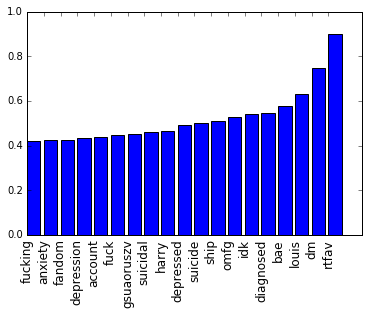

In [211]:
import matplotlib.pyplot as plt
x_ticks_labels = names
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(names)),test)
ax.set_xticks(range(len(names)))
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
plt.savefig('depressed', bbox_inches='tight')

## Analyze Top Words for PTSD

<type 'numpy.ndarray'>
(3, 68796)
20


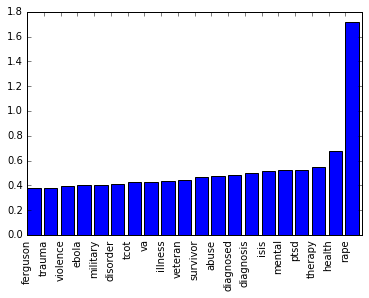

In [207]:
coef = logreg.coef_
print(type(coef))
print(coef.shape)
ind = np.argpartition(coef[2], -20)[-20:]
ind = ind[np.argsort(coef[2][ind])]
vocab = vectorizer.vocabulary_
names = []
for name, index in vocab.items():    # for name, age in list.items():  (for Python 3.x)
    if index in ind:
        names.append(name)
print(len(names))
x_ticks_labels = names
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(names)),coef[2][ind])
ax.set_xticks(range(len(names)))
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=10)
#plt.show()
plt.savefig('ptsd', bbox_inches='tight')

## Analyze Top Words for Control

[35324 54112 33893 10601 27591 23161 37296 32427 32042 24006 10373  5286
 31469 42461  6737 40178  4534 33589 39340 68785]
19


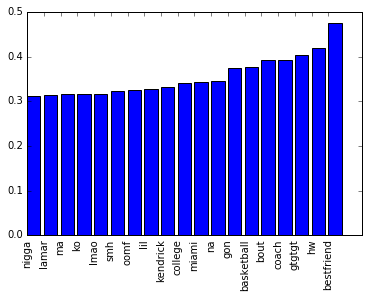

In [241]:
## Delete unwanted word
test = list(coef[0][ind])
# del test[-1]
# print(test)
ind = np.argpartition(coef[0], -20)[-20:]
ind = ind[np.argsort(coef[0][ind])]
print(ind)
vocab = vectorizer.vocabulary_
names = []
for name, index in vocab.items():
    if index in ind:
        names.append(name)
print(len(names))
x_ticks_labels = names
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(names)),test)
ax.set_xticks(range(len(names)))
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=10)
#plt.show()
plt.savefig('control', bbox_inches='tight')


## Accuracy of Logistic Regression

In [87]:
y_pred = logreg.predict(X_new_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_new_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


## Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[216,  11,   5],
       [ 53,  50,  12],
       [ 55,  15,  53]])

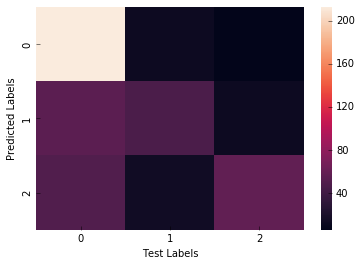

In [222]:
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
xcm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
xcm=numpy.array(xcm)
ax = sns.heatmap(xcm)
plt.xlabel('Test Labels')
plt.ylabel('Predicted Labels')
#plt.show()
plt.savefig('ConfusionMatrix')

## Naive Bayes

In [225]:
## Naive Bayes
from sklearn.naive_bayes import GaussianNB
#nb = cross_val_score(MultinomialNB(), X_new, y,cv=3)
#print("Naive Bayes average accuracy : ",nb.mean())
clf = GaussianNB().fit(X_new.toarray(), y)
y_pred = clf.predict(X_new_test.toarray())
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(clf.score(X_new_test.toarray(), y_test)))

Accuracy of Naive Bayes classifier on test set: 0.48
